In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mshaheermalik77","key":"13d751b739a360644611eab57a4f20b9"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d ayuraj/asl-dataset
!unzip -q asl-dataset.zip -d asl_dataset

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
 97% 55.0M/56.9M [00:00<00:00, 568MB/s]
100% 56.9M/56.9M [00:00<00:00, 551MB/s]


In [ ]:
!rm -r /content/asl_dataset

In [ ]:

!kaggle datasets download -d ayuraj/asl-dataset
!unzip -q asl-dataset.zip -d asl_data_my

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
asl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import shutil
shutil.rmtree('asl_data_my/asl_dataset/asl_dataset')

In [ ]:
#Split the dataset randomly into training,testing and validation
import os  #Os allows interactions with folders/file systems
import shutil #Allows copying of files from directories
import random #Used for random and fair distribution of data into datasets for training etc
from tqdm import tqdm #Loading bar

data_directory='/content/asl_data_my/asl_dataset'
target_directory='/content/split_asl_dataset'
#Three folders are made for training, testing and validation.
for split in ['train','val','test']:
  path_split=os.path.join(target_directory,split)
  os.makedirs(path_split,exist_ok=True)


In [ ]:
import shutil
shutil.rmtree('content')

FileNotFoundError: [Errno 2] No such file or directory: 'content'

In [ ]:
import os
import shutil
import random
from tqdm import tqdm

data_directory = '/content/asl_data_my/asl_dataset'
target_directory = '/content/split_asl_dataset'

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for name_folder in tqdm(os.listdir(data_directory)):#This shows everything that is inside the original directory
    folder_path = os.path.join(data_directory, name_folder)#Takes class folders
    if not os.path.isdir(folder_path):
        continue

    images = os.listdir(folder_path)
    random.shuffle(images) #Random shuffling of all images to then be distributed

    total = len(images)
    for_train = int(total * train_ratio)
    for_val = for_train + int(total * val_ratio)

    splits = {
        'train': images[:for_train],
        'val': images[for_train:for_val],
        'test': images[for_val:]
    }

    for split, split_images in splits.items():
        split_class_dir = os.path.join(target_directory, split, name_folder)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in split_images:
            src_path = os.path.join(folder_path, img_name) #/content/asl_data_my/asl_dataset/A/image1.jpg
            dst_path = os.path.join(split_class_dir, img_name) #/content/split_asl_datset/train/A/image1.jpg
            shutil.copy(src_path, dst_path)

print("Dataset split complete!")






100%|██████████| 36/36 [00:00<00:00, 126.93it/s]

Dataset split complete!


In [ ]:
#Normalization and Data Augmentation
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


data_directory='/content/split_asl_dataset'
#A pretrained MobileNetV2 model is used
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


val_test_transformers=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_dataset = ImageFolder(root=os.path.join(data_directory, "train"), transform=train_transformers)
val_dataset = ImageFolder(root=os.path.join(data_directory, "val"), transform=val_test_transformers)
test_dataset = ImageFolder(root=os.path.join(data_directory, "test"), transform=val_test_transformers)

train_loaders=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loaders=DataLoader(val_dataset,batch_size=32,shuffle=False)
test_loaders=DataLoader(test_dataset,batch_size=32,shuffle=False)



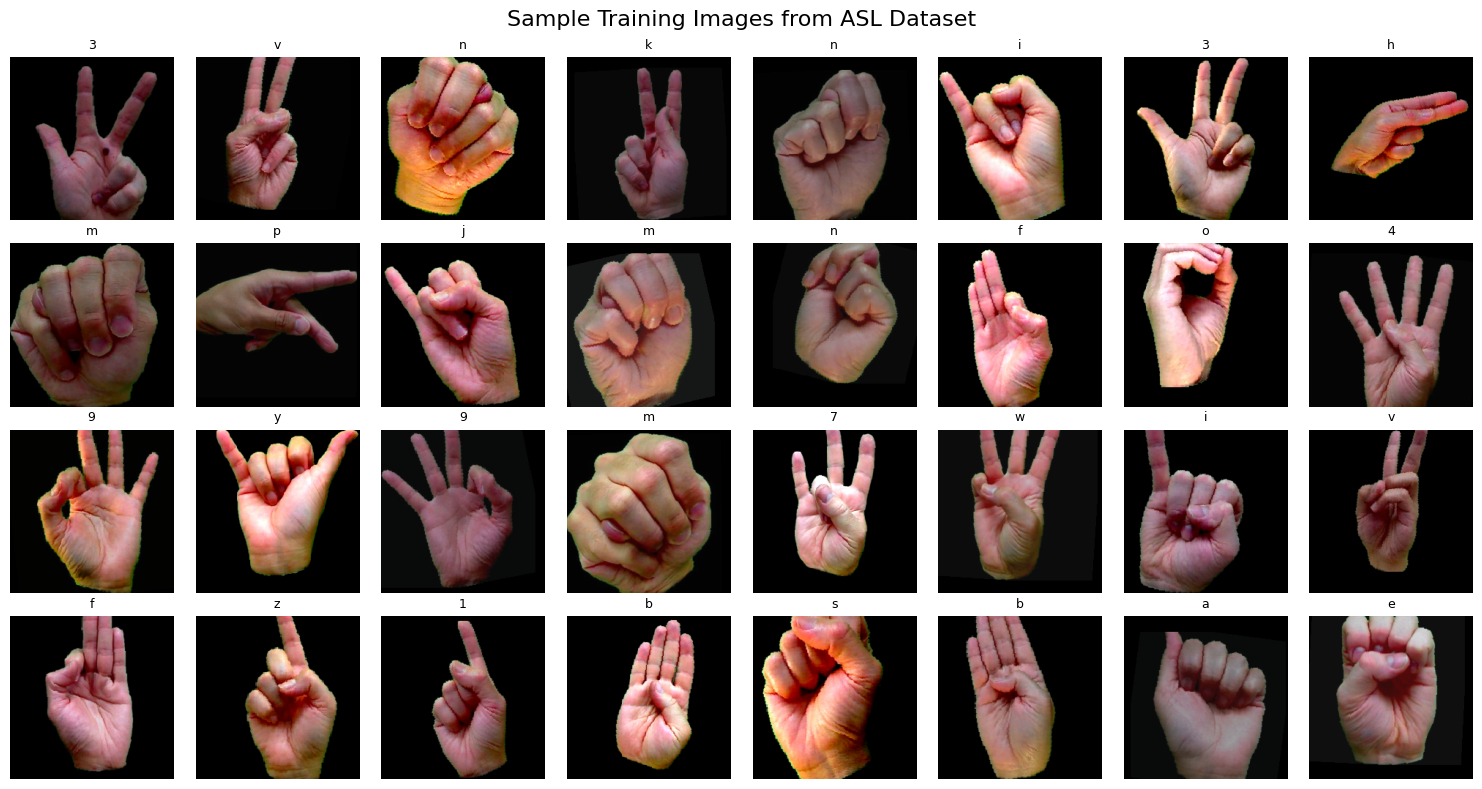

In [ ]:
#Visualization
import matplotlib.pyplot as plt
import numpy as np

# Undoes naormalization so we can see the images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  #Standard values for the model
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

#Pick a bunch of images
dataiter = iter(train_loaders)
images, labels = next(dataiter)

#32 Image grid, labelled
plt.figure(figsize=(15, 8))
for i in range(32):
    plt.subplot(4, 8, i+1)  #4x8
    imshow(images[i])
    plt.title(train_dataset.classes[labels[i]], fontsize=9)
    plt.axis('off')

plt.suptitle("Sample Training Images from ASL Dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#Training the model
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

model=models.mobilenet_v2(pretrained=True)
for param in model.features.parameters():
  param.requires_grad= false

classes_NUMBER=36
model.classifier[1]=nn.Linear(model.classifier[1].in_features,classes_NUMBER)

loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loaders:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  #Clear previous gradient
        outputs = model(images) #Forward Pass to get output
        loss = loss_function(outputs, labels) #Comparison of output with actual labels
        loss.backward() #Back Propogation, finding error contribution of weights
        optimizer.step() #Adjusting weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total

    #Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loaders:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss:.4f} |  Train Accuracy: {train_accuracy:.2f}% |  Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/10]  Loss: 74.7650 |  Train Accuracy: 60.34% |  Validation Accuracy: 74.37%
Epoch [2/10]  Loss: 24.4021 |  Train Accuracy: 84.66% |  Validation Accuracy: 82.17%
Epoch [3/10]  Loss: 18.2079 |  Train Accuracy: 88.30% |  Validation Accuracy: 86.07%
Epoch [4/10]  Loss: 14.3352 |  Train Accuracy: 90.80% |  Validation Accuracy: 91.36%
Epoch [5/10]  Loss: 15.0914 |  Train Accuracy: 90.57% |  Validation Accuracy: 88.30%
Epoch [6/10]  Loss: 12.1102 |  Train Accuracy: 91.65% |  Validation Accuracy: 93.59%
Epoch [7/10]  Loss: 12.6241 |  Train Accuracy: 91.93% |  Validation Accuracy: 96.38%
Epoch [8/10]  Loss: 10.2382 |  Train Accuracy: 93.01% |  Validation Accuracy: 91.64%
Epoch [9/10]  Loss: 8.5341 |  Train Accuracy: 94.20% |  Validation Accuracy: 93.31%
Epoch [10/10]  Loss: 8.5210 |  Train Accuracy: 94.72% |  Validation Accuracy: 94.71%


In [ ]:
model.eval()
class_names = sorted(os.listdir('/content/split_asl_dataset/train'))  #Label names

with torch.no_grad():
    for test_images, test_labels in test_loaders:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        outputs = model(test_images)
        _, preds = torch.max(outputs, 1)

        for i in range(test_images.size(0)):  # A loop is done through each image in the batch
            actual = class_names[test_labels[i].item()]
            predicted = class_names[preds[i].item()]
            print("Actual label is : ", actual," Predicted label is: ", predicted)


Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  0  Predicted label is:  o
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  z
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  1
Actual label is :  1  Predicted label is:  z
Actual lab

In [ ]:
torch.save(model.state_dict(), 'best_sign_model.pth') #Saving and downloading the model for web inference

In [ ]:
from google.colab import files
files.download('best_sign_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>